# **Life Expectancy**

## Table of Contents
* [Problem Statement](#chapter1)

* [Libraries](#chapter2)

* [Data](#chapter3)
    * [Columns Description](#section_3_1)
    
* [Exploratory Data Analysis](#chapter4)

* [Preprocessing](#chapter5)
    * [Data Cleaning](#section_5_1)
    * [Feature Selection/Enineering/Scaling](#section_5_2)
    * [Pipeline](#section_5_3)

* [Modeling](#chapter6)

* [Tune model](#chapter7)
    * [Randomized Search](#section_7_1)
    
* [Validation](#chapter8)

* [Conclusion](#chapter9)

# Problem Statement <a class="anchor" id="chapter1"></a>

- The objective of this project is to perform an analysis on the Life Expectancy dataset from the World Health Organization (WHO). It contains various metrics of a country over 14 years, including life expectancy.

- At the end of this notebook, the goal is to determine and predict the life expectancy of a country based on the other provided metrics, as well as to identify which ones have the greatest impact on life expectancy. 

# Libraries <a class="anchor" id="chapter2"></a>

In [1]:
#Data Manipulatio
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy.stats import zscore, loguniform, randint 
import math

#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
colors = ['#c1121f','#669bbc', '#f4d35e', '#e9724c', '#ffc857']
plt.style.use('seaborn-white')
plt.rc('figure', figsize=(12,8))
plt.rc('font', size=18)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Models
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

#Metrics and Tuning
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from yellowbrick.regressor import PredictionError, ResidualsPlot

#General
import warnings
warnings.filterwarnings(action='ignore')

# Data <a class="anchor" id="chapter3"></a>

In [2]:
#Import data
df_life = pd.read_csv('/kaggle/input/life-expectancy-who/Life Expectancy Data.csv')

print('------ Dataset ------')
print(f'Number of rows: {df_life.shape[0]}')
print(f'Number of columns: {df_life.shape[1]}')

df_life.head()

------ Dataset ------
Number of rows: 2938
Number of columns: 22


Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   \
0             62     0.01               71.279624         65.0      1154   
1             64     0.01               73.523582         62.0       492   
2             66     0.01               73.219243         64.0       430   
3             69     0.01               78.184215         67.0      2787   
4             71     0.01                7.097109         68.0      3013   

    BMI   under-five deaths   Polio  Total expenditure  Diphtheria   \
0   19.1                  83    6.0               8.16         65.0   
1   18.6                  86   58.0               8.18         62.0   
2   18.1                  89   62.0               8.13         64.0   
3   17.6                  93   67.0               8.52         67.0   
4   17.2                  97   68.0               7.87         68.0   

    HIV/AIDS         GDP  Population   thinness  1-19 years  \
0        0.1  584.259210  33736494.0                   17.2   
1        0.1  612.696514    327582.0                   17.5   
2        0.1  631.744976  31731688.0                   17.7   
3        0.1  669.959000   3696958.0                   17.9   
4        0.1   63.537231   2978599.0                   18.2   

    thinness 5-9 years  Income composition of resources  Schooling  
0                 17.3                            0.479       10.1  
1                 17.5                            0.476       10.0  
2                 17.7                            0.470        9.9  
3                 18.0                            0.463        9.8  
4                 18.2                            0.454        9.5

## Columns Description <a class="anchor" id="section_3_1"></a>

- **Country**: Country

- **Year**: Year

- **Status**: Classification of countries as 'developed' or 'developing' based on their gross domestic product(GDP).$^1$ 

- **Life expectancy**: Life expectancy (years of age).           

- **Adult Mortality**: Adult Mortality Rates of both sexes (Probability of dying between 15 and 60 years per 1000 population).

- **Infant deaths**: Number of Infant (0-1 year of age) Deaths per 1000 population.

- **Alcohol**: Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol).

- **Percentage expenditure**: Expenditure on health as a percentage of GPD per capita. (%)

- **Hepatitis B**: Hepatitis B immunization coverage among 1-year-olds. (%)

- **Measles**: Number of reported cases per 1000 population.

- **BMI**: Average Body Mass index of entire population

- **Under-five deaths**: Number of under-five deaths per 1000 population

- **Polio**: Polio immunization coverage among 1-year-olds (%)

- **Total expenditure**: General government expenditure on health as a percentage of total government expenditure (%)

- **Diphtheria**: Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)

- **HIV/AIDS**: Deaths per 1000 live births HIV/AIDS (0-4 years)

- **GDP**: Gross Domestic Product per capita (in USD)

- **Population**: Population of the country

- **Thinness 1-19 years**: Prevalence of thinness among children and adolescents for Age 10 to 19 (%)$^2$

- **Thinness 5-9 years**: Prevalence of thinness among children for Age 5 to 9 (%)

- **Income composition of resources**: Human Development Index in terms of income composition of resources (index ranging from 0 to 1)

- **Schooling**: Number of years of Schooling (years)

<br/>
$^1$ This type of classification is not accurate or comprehensive since there are many other indicators of development that should be taken into account.

$^2$ The column should be named 'Thinness 10-19 years'. This error will be corrected below.

# Exploratory Data Analysis <a class="anchor" id="chapter4"></a>

In [3]:
#Check that the columns description match the data format.
df_life.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

- As expected, there are only two object columns, 'Country' and 'Status', while the rest are numerical.

In [4]:
#Fix columns names formatting errors
columns_name_fixed = []

for column in df_life.columns:
    if column == ' thinness  1-19 years':
        column = 'Thinness 10-19 years'
    else:
        column = column.strip(' ').replace("  ", " ")
        column = column[:1].upper() + column[1:]
        
    columns_name_fixed.append(column)

df_life.columns = columns_name_fixed

In [5]:
df_life.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   Infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   Percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  Under-five deaths                2938 non-null   int64  
 12  Polio               

- Firstly, let's analyze how the categorical feature 'Status', which defines the country as either 'Developed' or 'Developing', relates to the target.

- To improve code readability when creating plots, a new dataset will be created divided into two distinct groups based on the "Developed" and "Developing" criteria.

In [6]:
#New dataframes
df_developed = df_life.loc[df_life['Status']=='Developed'].copy()
df_developing = df_life.loc[df_life['Status']=='Developing'].copy()

In [7]:
# Plot the density of life expectancy by country status
sns.kdeplot(df_developed['Life expectancy'],  # Plot the density of life expectancy for developed countries
            label='Developed',  # Label the developed countries' density plot
            fill=True,  # Fill the area under the density curve
            color = colors[0],  # Set the color of the developed countries' density plot
            alpha = 0.8)  # Set the transparency of the developed countries' density plot

sns.kdeplot(df_developing['Life expectancy'],  # Plot the density of life expectancy for developing countries
            label='Developing',  # Label the developing countries' density plot
            fill=True,  # Fill the area under the density curve
            color=colors[1],  # Set the color of the developing countries' density plot
            alpha = 0.8)  # Set the transparency of the developing countries' density plot

plt.legend(loc='upper left')  # Add a legend to the plot
plt.ylabel('Density')  # Label the y-axis as "Density"
plt.xlim(30,95)  # Set the limits of the x-axis
plt.xlabel('Life Expectancy (years)')  # Label the x-axis as "Life Expectancy (years)"
plt.title('Life Expectancy based on Status \n', fontsize=18);  # Set the title of the plot

- Countries categorized as 'Developed' have a distribution of life expectancy that is more to the right, indicating that this value is higher in those countries.

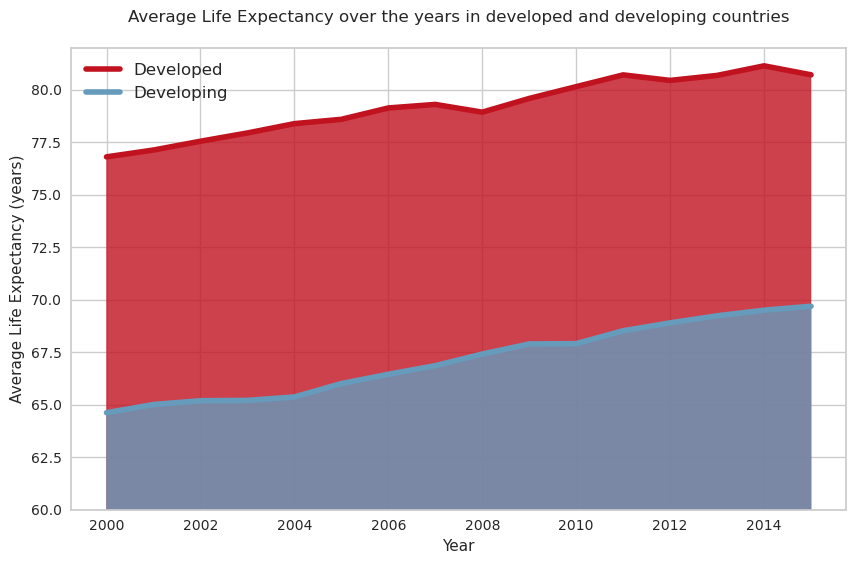

In [8]:
# Plot average Life Expectancy over the years
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df_developed.groupby('Year')['Life expectancy'].mean(),
       label='Developed',
       color=colors[0],
       linewidth=4)

# Fill area between the line plot and the x-axis
ax.fill_between(df_developed.groupby('Year')['Life expectancy'].mean().index,
                df_developed.groupby('Year')['Life expectancy'].mean().values,
                color=colors[0],
                alpha=0.8) 

ax.plot(df_developing.groupby('Year')['Life expectancy'].mean(),
       label='Developing',
       color=colors[1],
       linewidth=4,)

ax.fill_between(df_developing.groupby('Year')['Life expectancy'].mean().index,
                df_developing.groupby('Year')['Life expectancy'].mean().values,
                color=colors[1],
                alpha=0.8) 

plt.legend(loc='upper left', fontsize=12)
ax.set_xlabel('Year')
ax.set_ylabel('Average Life Expectancy (years)')

# Set y-axis limits
ax.set_ylim(60,82)

ax.set_title('Average Life Expectancy over the years in developed and developing countries\n');

For the **numerical features**, we are going to plot a matrix of correlation and then use those correlations to guide the creation of more specific graphs to further explore the dataset.

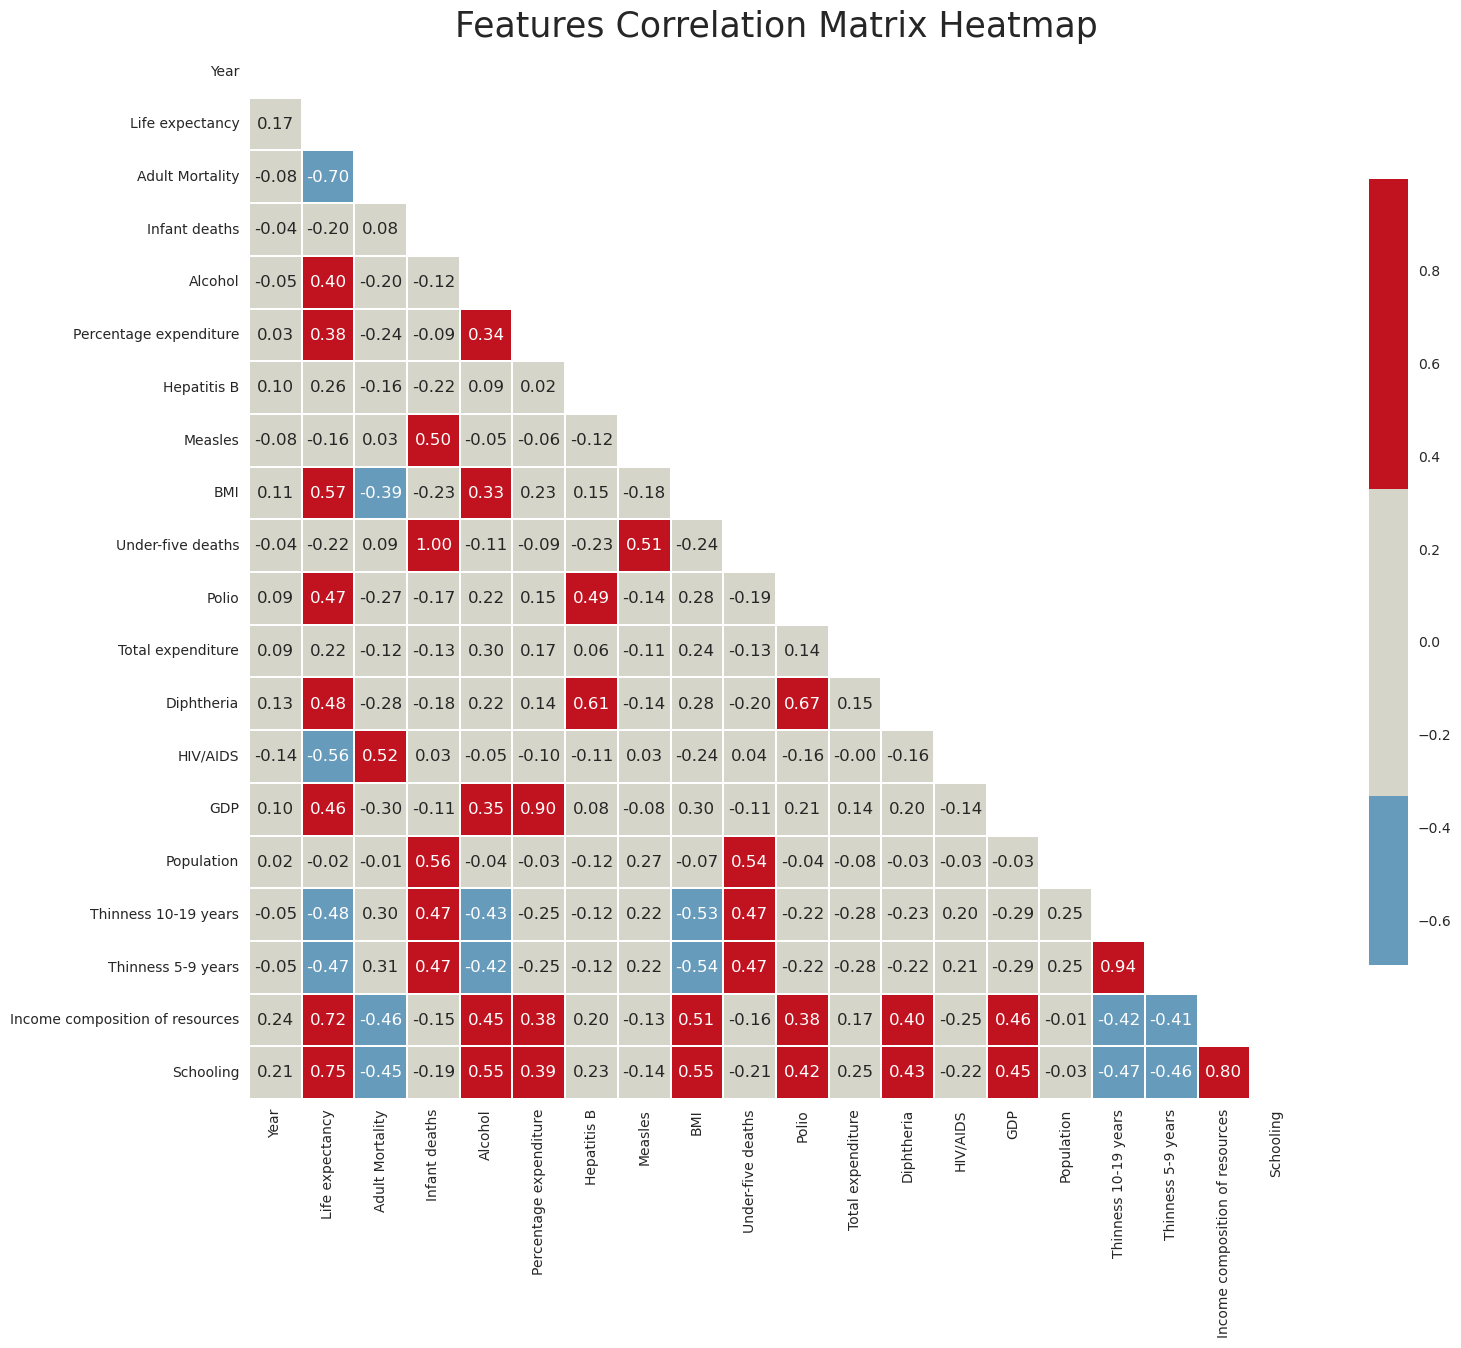

In [9]:
#Plot Matrix of Correlation
plt.figure(figsize=(17,17))

heatmap_colors = [colors[1], '#d6d5c9', colors[0]]

corr = df_life.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(df_life.corr(), 
            mask=mask,
            center=0,
            annot=True,
            fmt='.2f',
            cmap=heatmap_colors,
            square=True,
            linewidths=.2,
            cbar_kws={"shrink": .6})

plt.title('Features Correlation Matrix Heatmap', fontsize=25);

- The correlation matrix shows that the target has a high positive correlation with the features 'Schooling', 'Income composition of resources', and 'BMI', and a high negative correlation with the features 'Adult mortality' and 'HIV/AIDS'.
- It is worth noting that the features 'Schooling' and 'Income composition of resources' also have a high correlation between them, as do 'Adult mortality' and 'HIV/AIDS'.
- Although some variables do not have a high correlation with the target, it is important to visualize these relationships graphically. This is because the Pandas `corr()` method calculates Pearson correlation between variables, which only measures linear relationships and may not capture other types of relationships that the target may have with the other metrics.

In [10]:
#Function to plot scatter plots
def plot_scatterplot(df, features, title = 'Features', columns = 2, x_lim=None):
    
    df = df.copy()
    
    rows = math.ceil(len(features)/2)

    fig, ax = plt.subplots(rows, columns, sharey = True, figsize = (14,14))
    
    for i, feature in enumerate(features):
        ax = plt.subplot(rows, columns, i+1)
        sns.scatterplot(data = df,
                        x = feature,
                        y = 'Life expectancy',
                        hue = 'Status',
                        palette=[colors[1], colors[0]],
                        ax = ax)
        if (i == 0):
            ax.legend()
        else:
            ax.legend("")
        
    fig.legend(*ax.get_legend_handles_labels(), 
               loc='lower center', 
               bbox_to_anchor=(1.04, 0.5),
               fontsize='small')
    fig.suptitle('{} x Life Expectancy'.format(title), 
                 fontsize = 25, 
                 x = 0.56);

    fig.tight_layout(rect=[0.05, 0.03, 1, 1])

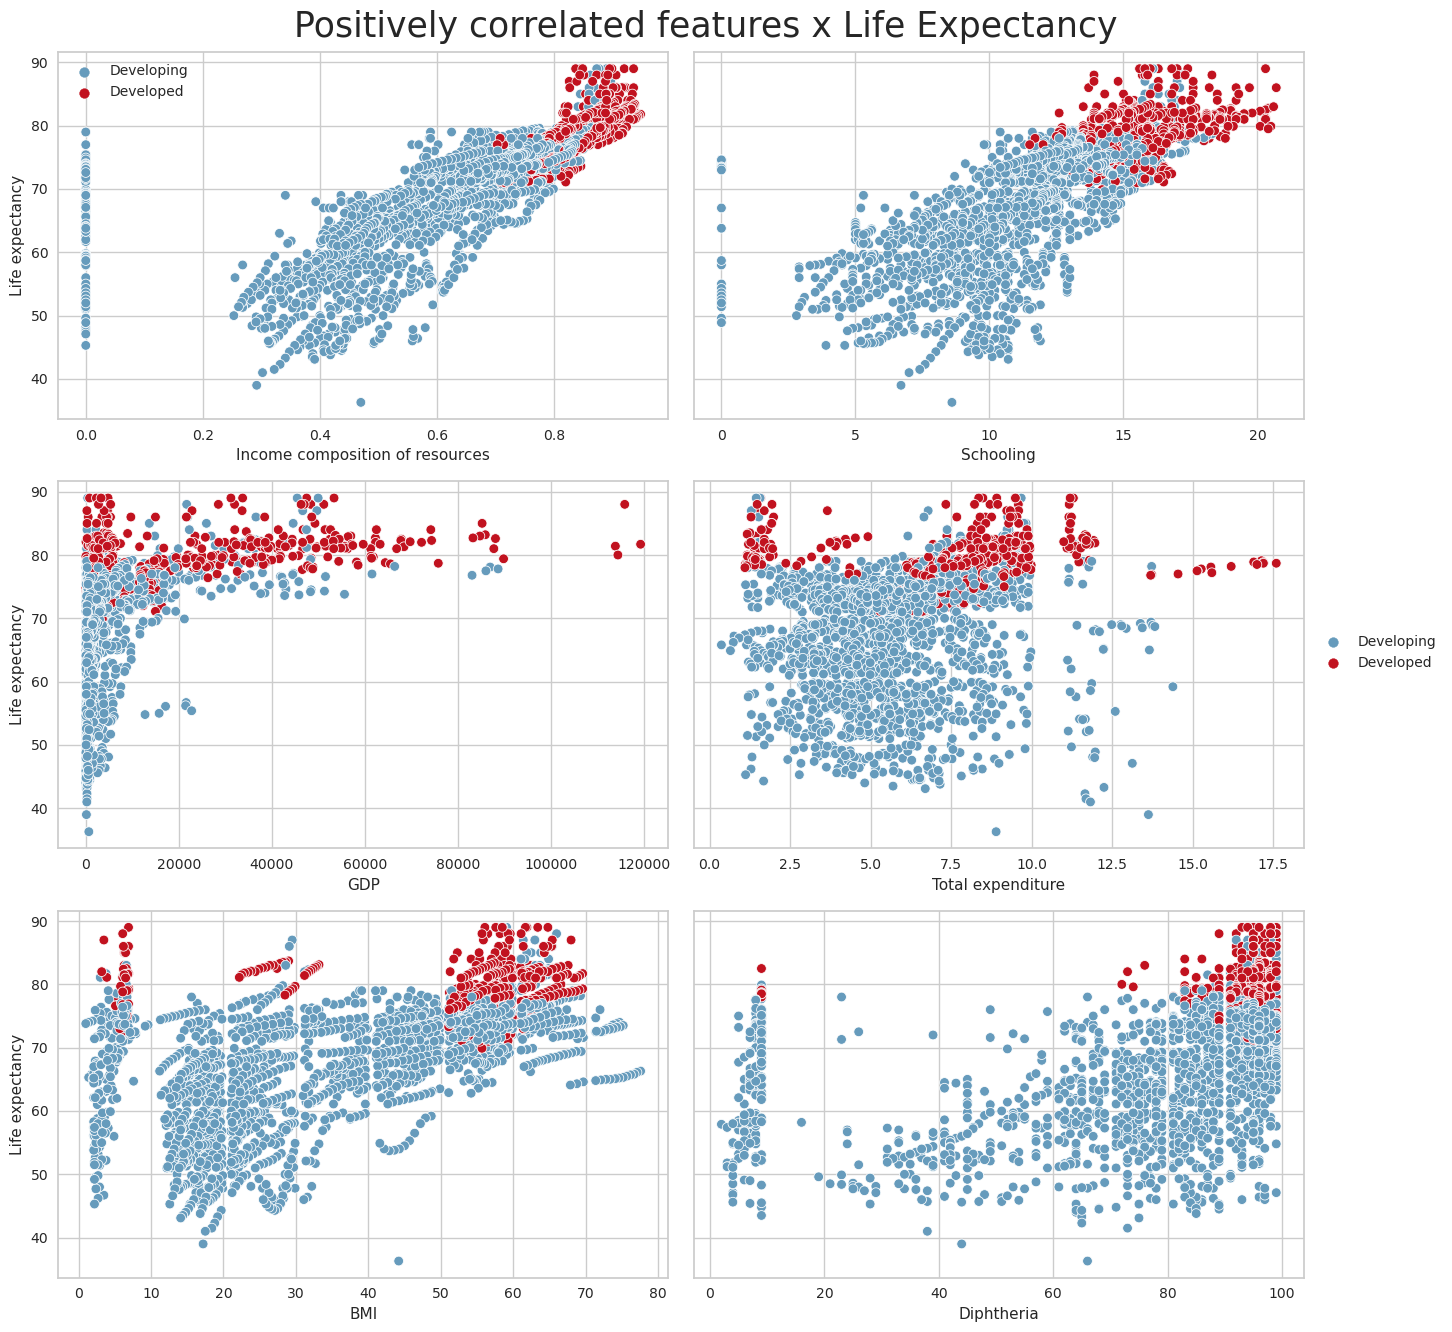

In [11]:
#Plot Life Expectancy x positively correlated features
pos_correlated_features = ['Income composition of resources', 'Schooling', 
                           'GDP', 'Total expenditure', 
                           'BMI', 'Diphtheria']

title = 'Positively correlated features'

plot_scatterplot(df_life, pos_correlated_features, title)

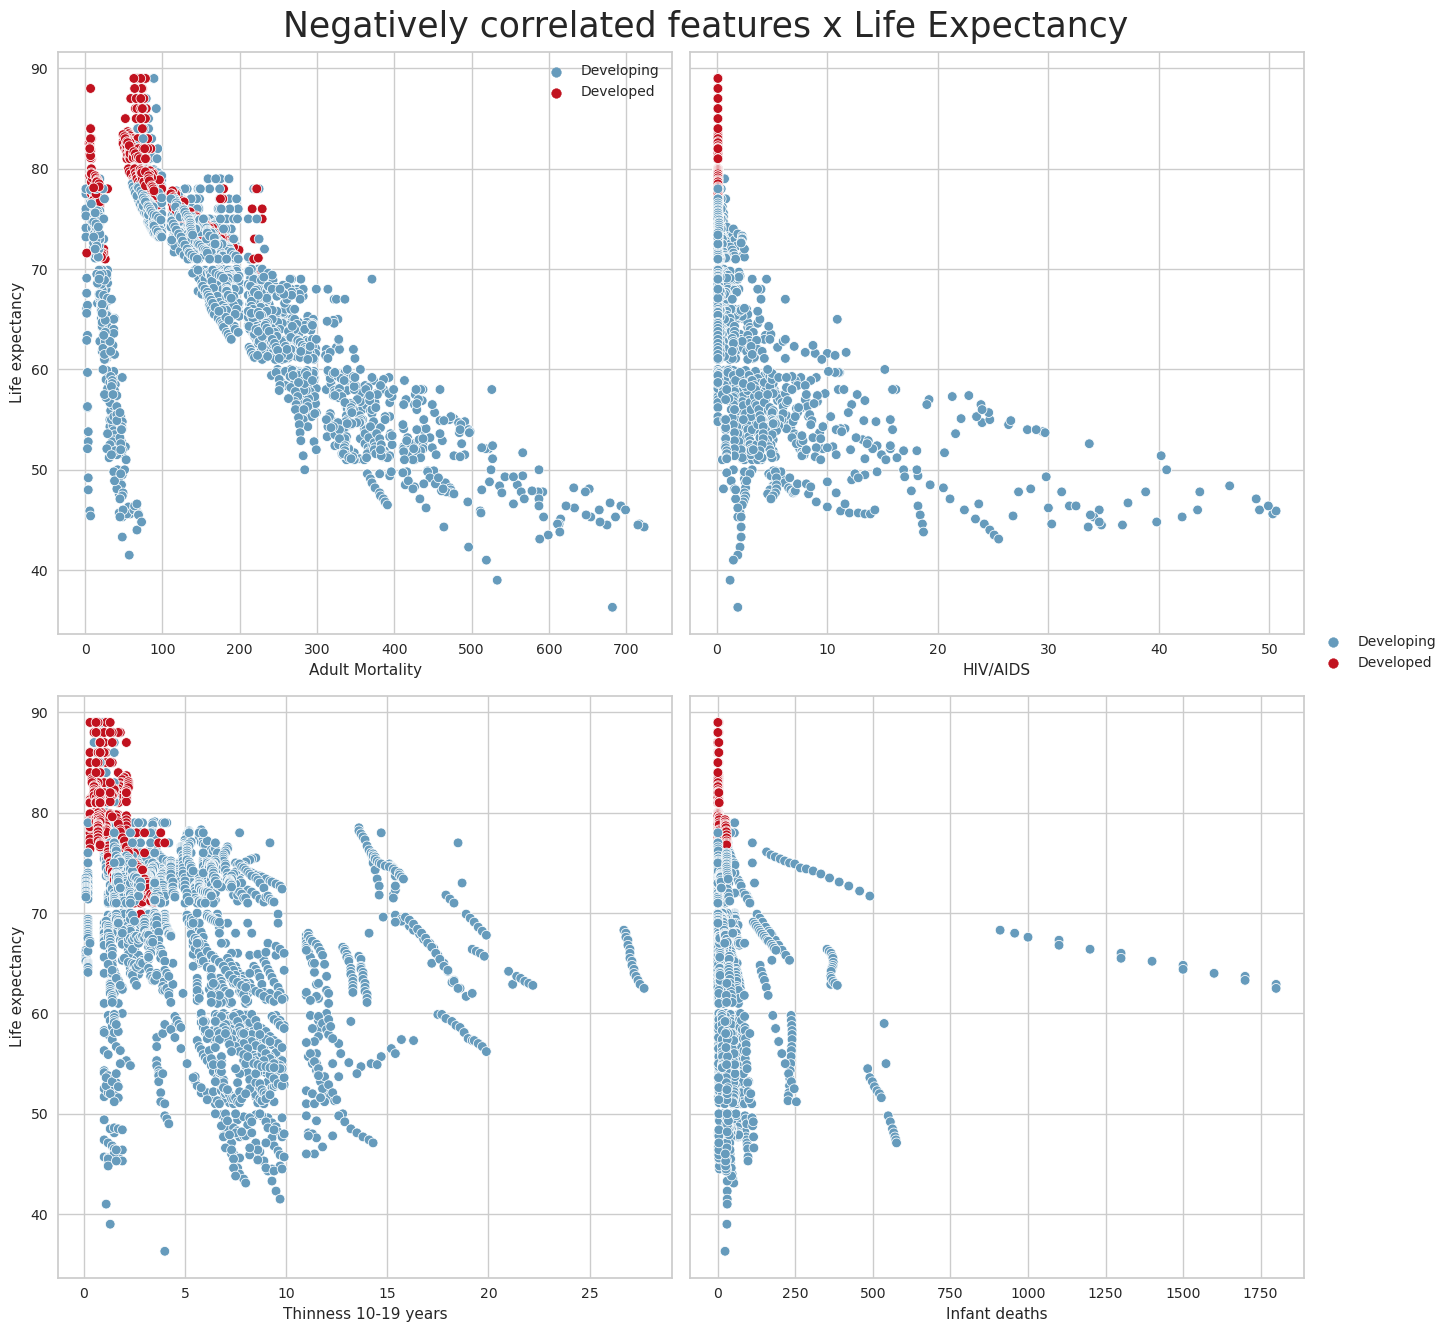

In [12]:
#Plot Life Expectancy x negatively correlated features
neg_correlated_features = ['Adult Mortality', 'HIV/AIDS', 
                           'Thinness 10-19 years', 'Infant deaths']

title = 'Negatively correlated features'

plot_scatterplot(df_life, neg_correlated_features, title)

plt.savefig('life_expecatancy_scatter_neg.jpg')

In [13]:
#Check other correlations
df_temp = df_life.loc[df_life['Population'] <= 1*1e7, :] 
features = ['Population', 'Alcohol']
plot_scatterplot(df_temp, features)

- It seems that the absolute number of a country's population does not have a direct relationship with life expectancy. Perhaps a more interesting variable would be population density, which can provide more clues about the country's social and geographical conditions.

- Another interesting point is that countries with the highest alcohol consumption also have the highest life expectancies. However, this seems to be the classic case for using the maxim 'Correlation does not imply causation'. The life expectancy of someone who owns a Ferrari is possibly higher than that of the rest of the population, but that does not mean that buying a Ferrari will increase their life expectancy. The same applies to alcohol. One hypothesis is that in developed countries, the population's average has better financial conditions, allowing for greater consumption of luxury goods such as alcohol.

- After checking the relationships of the dependent variable with the independent variables, it is important to analyze the distribution of these variables. Through them, it is possible to have the first clues if there are outliers in the dataset.


In [14]:
 #Function to plot distribution 
def plot_distribution(df, columns, title="Distribution of Features"):
    
    df = df.copy()
    
    rows = math.ceil(len(columns)/2)
    
    fig, ax = plt.subplots(rows, 2, figsize = (14,14))
    
    for i, column in enumerate(columns):
        ax = plt.subplot(rows, 2, i+1)

        sns.kdeplot(df_life.loc[df_life['Status']=='Developed', column], 
                    label='Developed',
                    fill=True, 
                    color = colors[0],
                    alpha = 0.8, 
                    ax = ax)

        sns.kdeplot(df_life.loc[df_life['Status']=='Developing',column], 
                    label = 'Developing',
                    fill = True,
                    color = colors[1],
                    alpha = 0.8,
                    ax = ax)
    
        ax.set_xlabel(column)
        ax.set_ylabel('')
    
    fig.legend(labels=['Developed', 'Developing'], 
               loc='center right', 
               bbox_to_anchor=(1.145, 0.5))
    
    fig.suptitle(title, 
                 fontsize=24,
                 x = 0.56);
    
    fig.text(0.04, 0.5, 
             'Density', 
             va='center', 
             rotation='vertical', 
             fontsize=16)
    
    fig.tight_layout(rect=[0.05, 0.03, 1, 1])

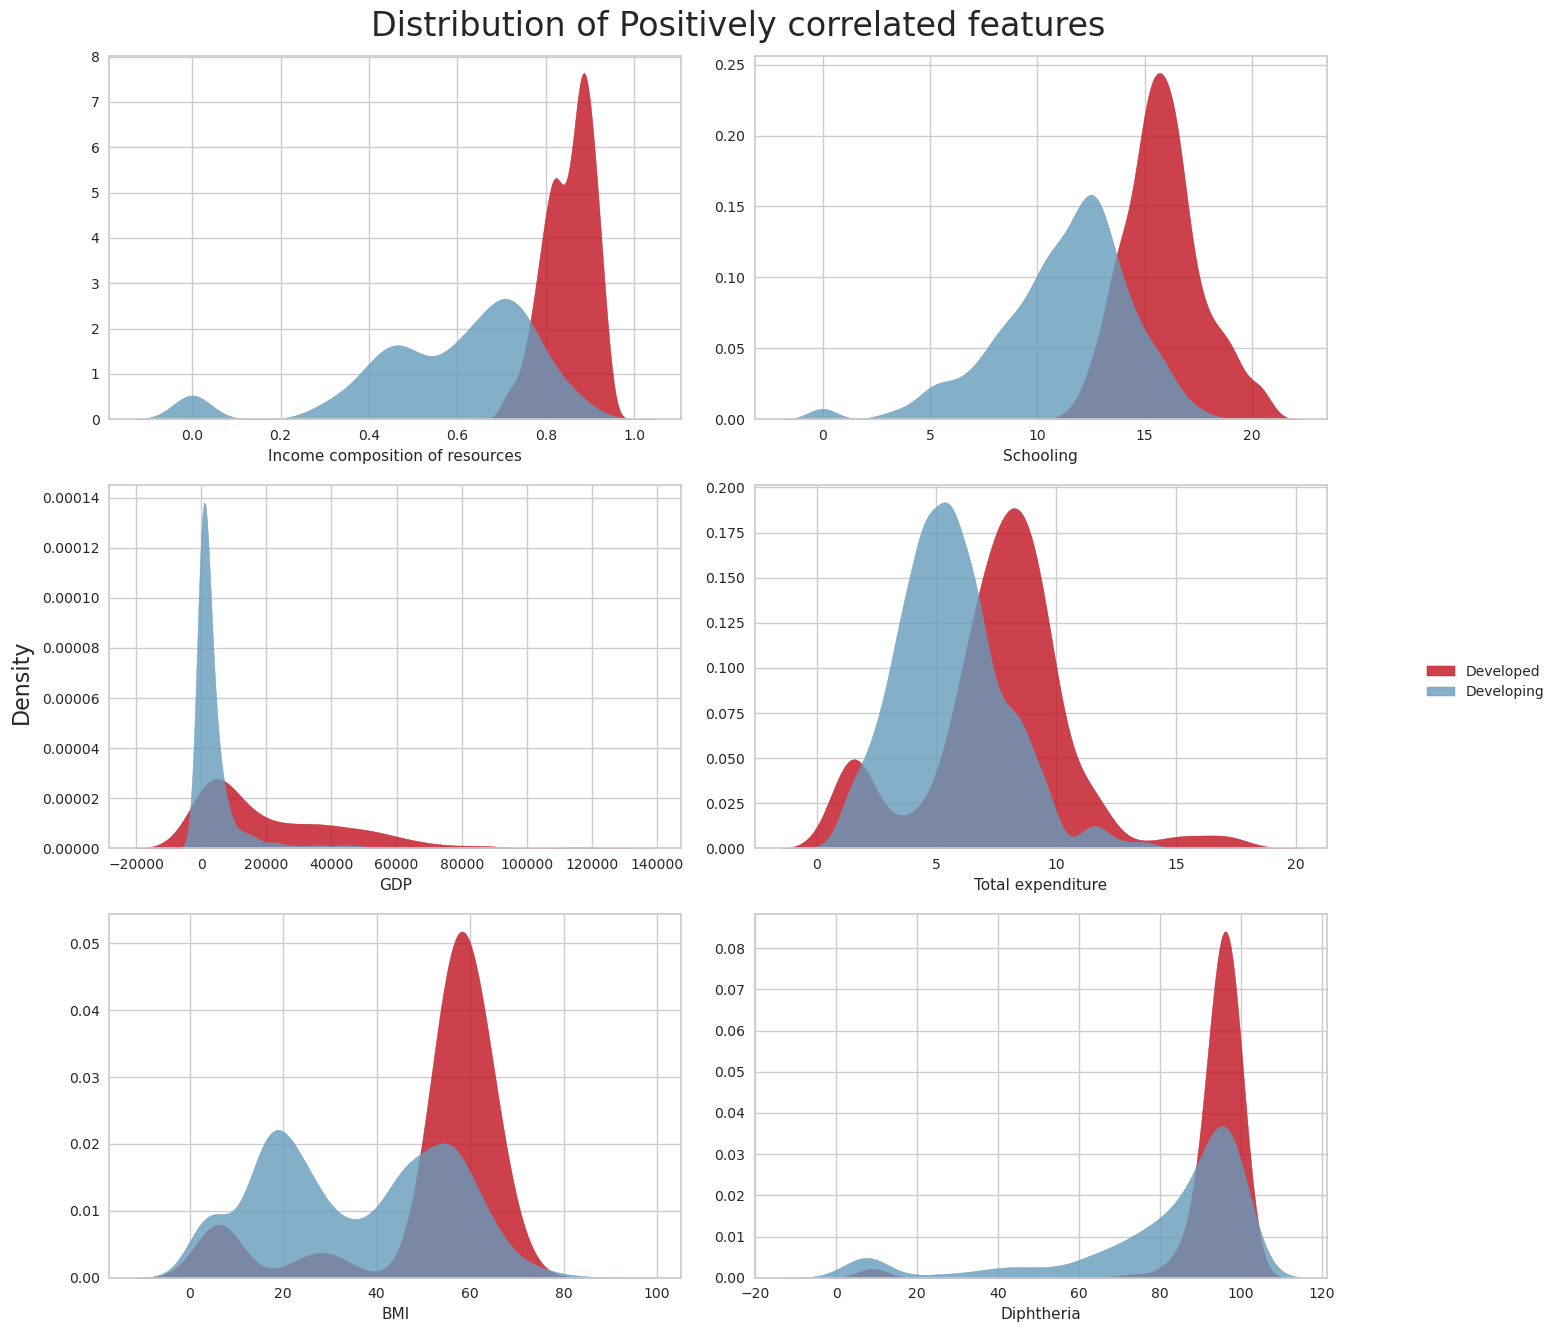

In [15]:
title = 'Distribution of Positively correlated features'
plot_distribution(df_life, pos_correlated_features, title)

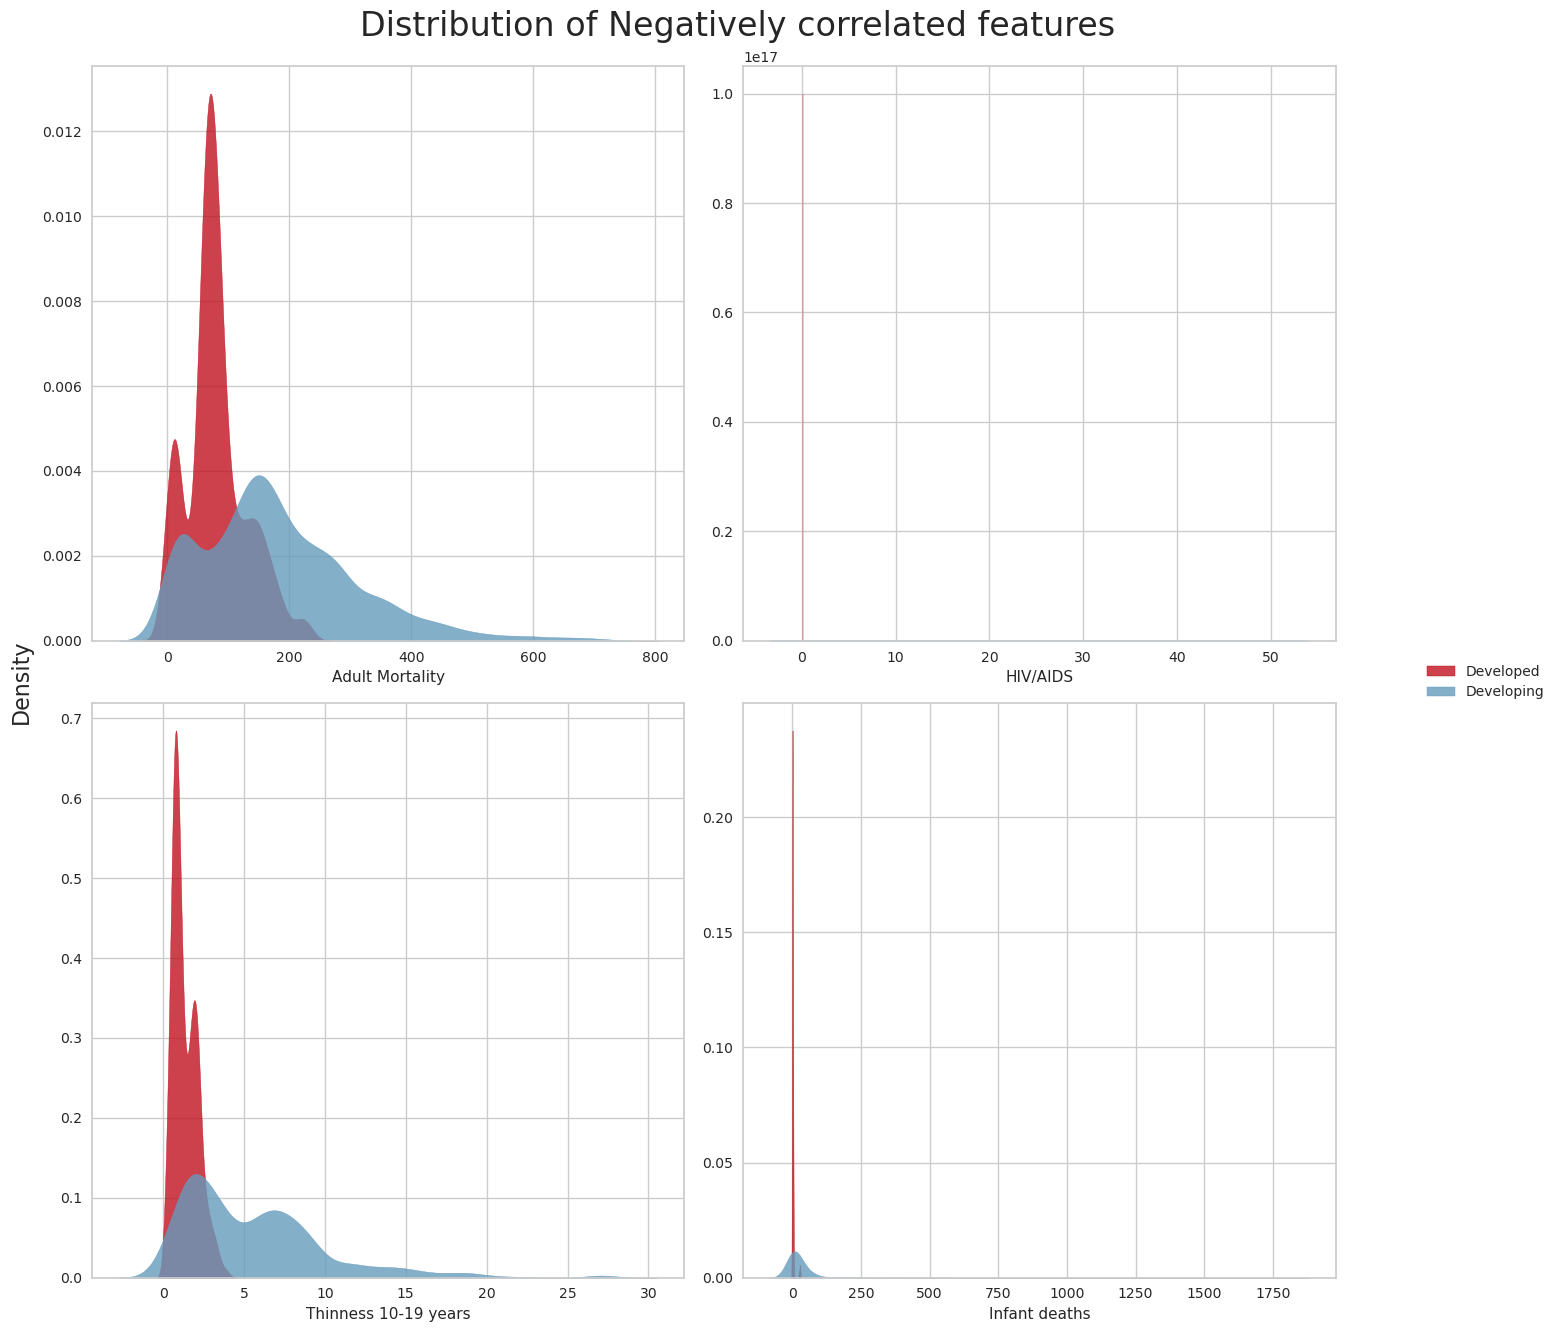

In [16]:
title = 'Distribution of Negatively correlated features'
plot_distribution(df_life, neg_correlated_features, title)

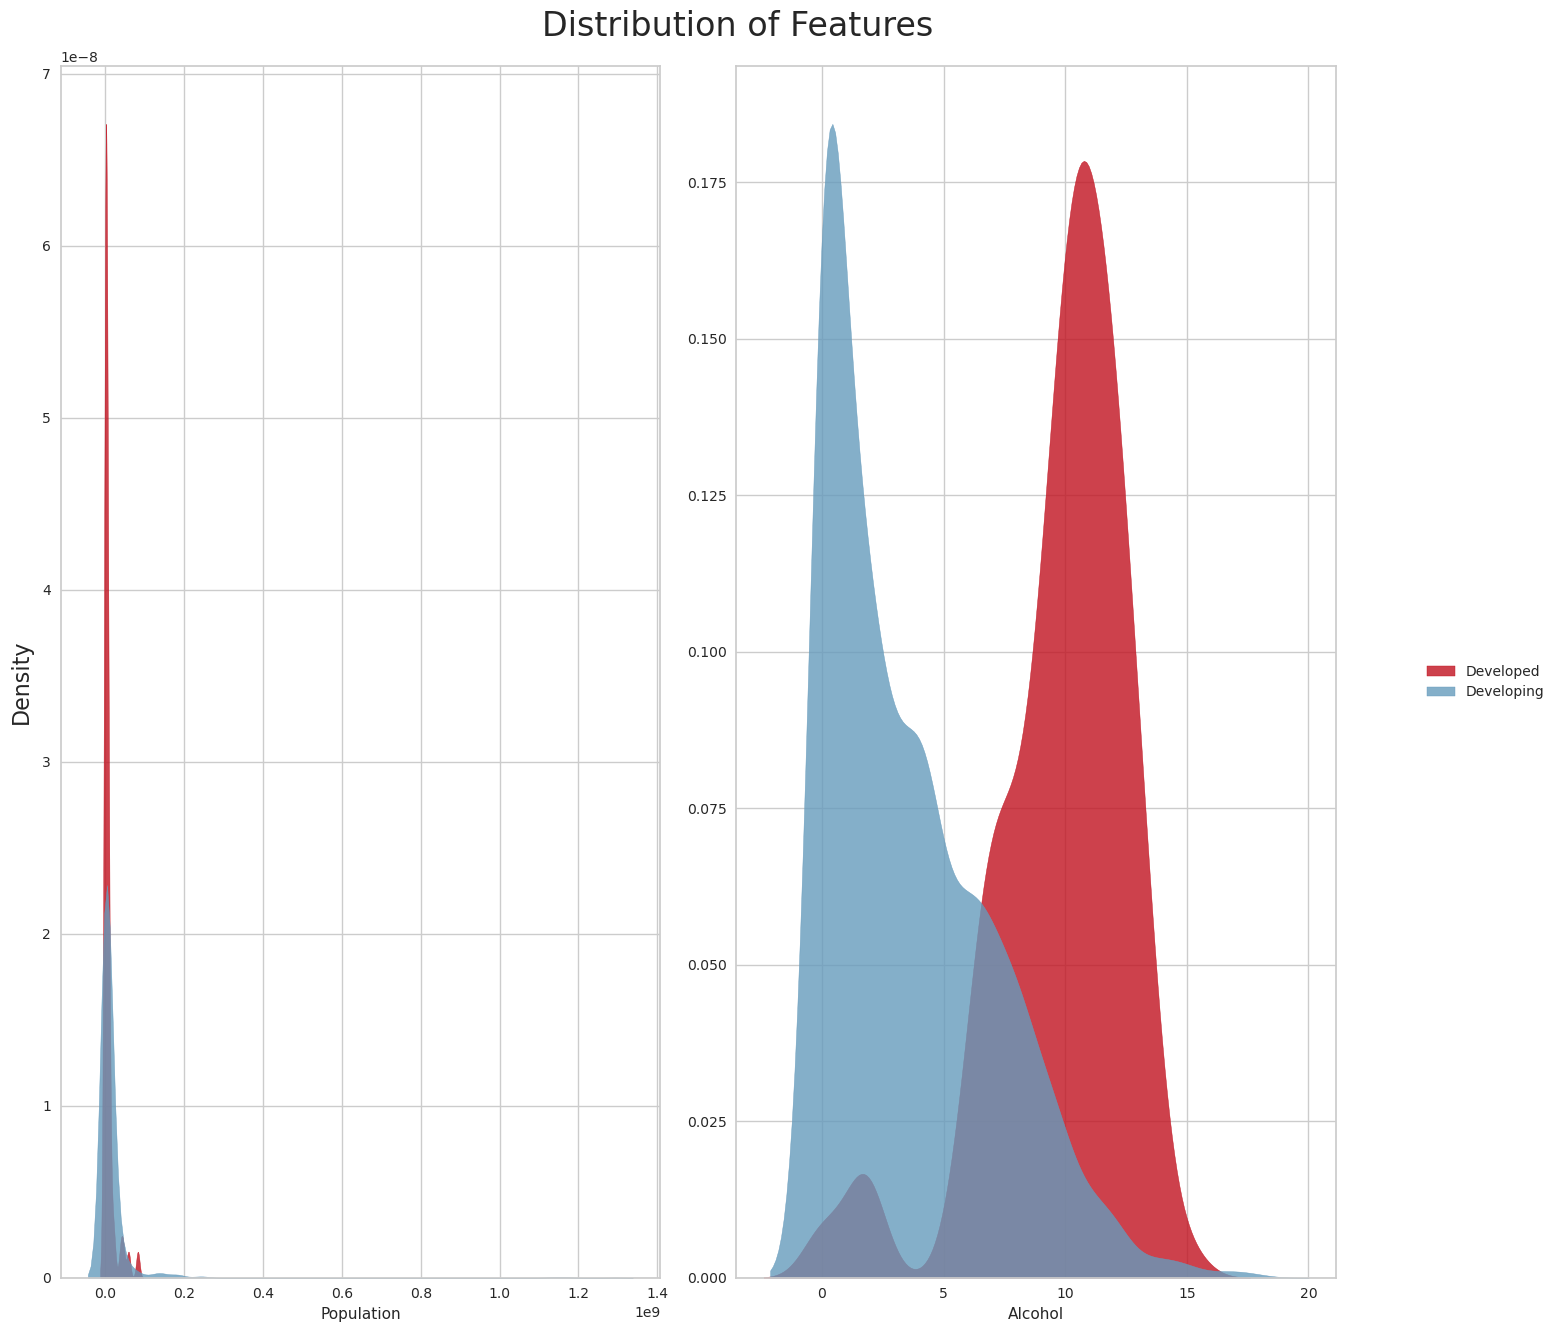

In [17]:
plot_distribution(df_temp, features)

In [18]:
#Function to plot box plot
def plot_boxplot(df, columns, title = 'Box plot of features'):
      
    df = df.copy()
    
    rows = math.ceil(len(columns)/2)
    
    fig, ax = plt.subplots(rows, 2, figsize = (14,14))
    
    for i, column in enumerate(columns):
        ax = plt.subplot(rows, 2, i+1)
        
        sns.boxplot(x = df[column], 
                    data = df, 
                    ax = ax, 
                    color = colors[0])
    
        ax.set_xlabel(column)
        ax.set_ylabel('')
    
    fig.suptitle(title, 
                 fontsize=24,
                 x = 0.56);
    
    fig.text(0.04, 0.5, 
             'Density', 
             va='center', 
             rotation='vertical', 
             fontsize=16)
    
    fig.tight_layout(rect=[0.05, 0.03, 1, 1])  

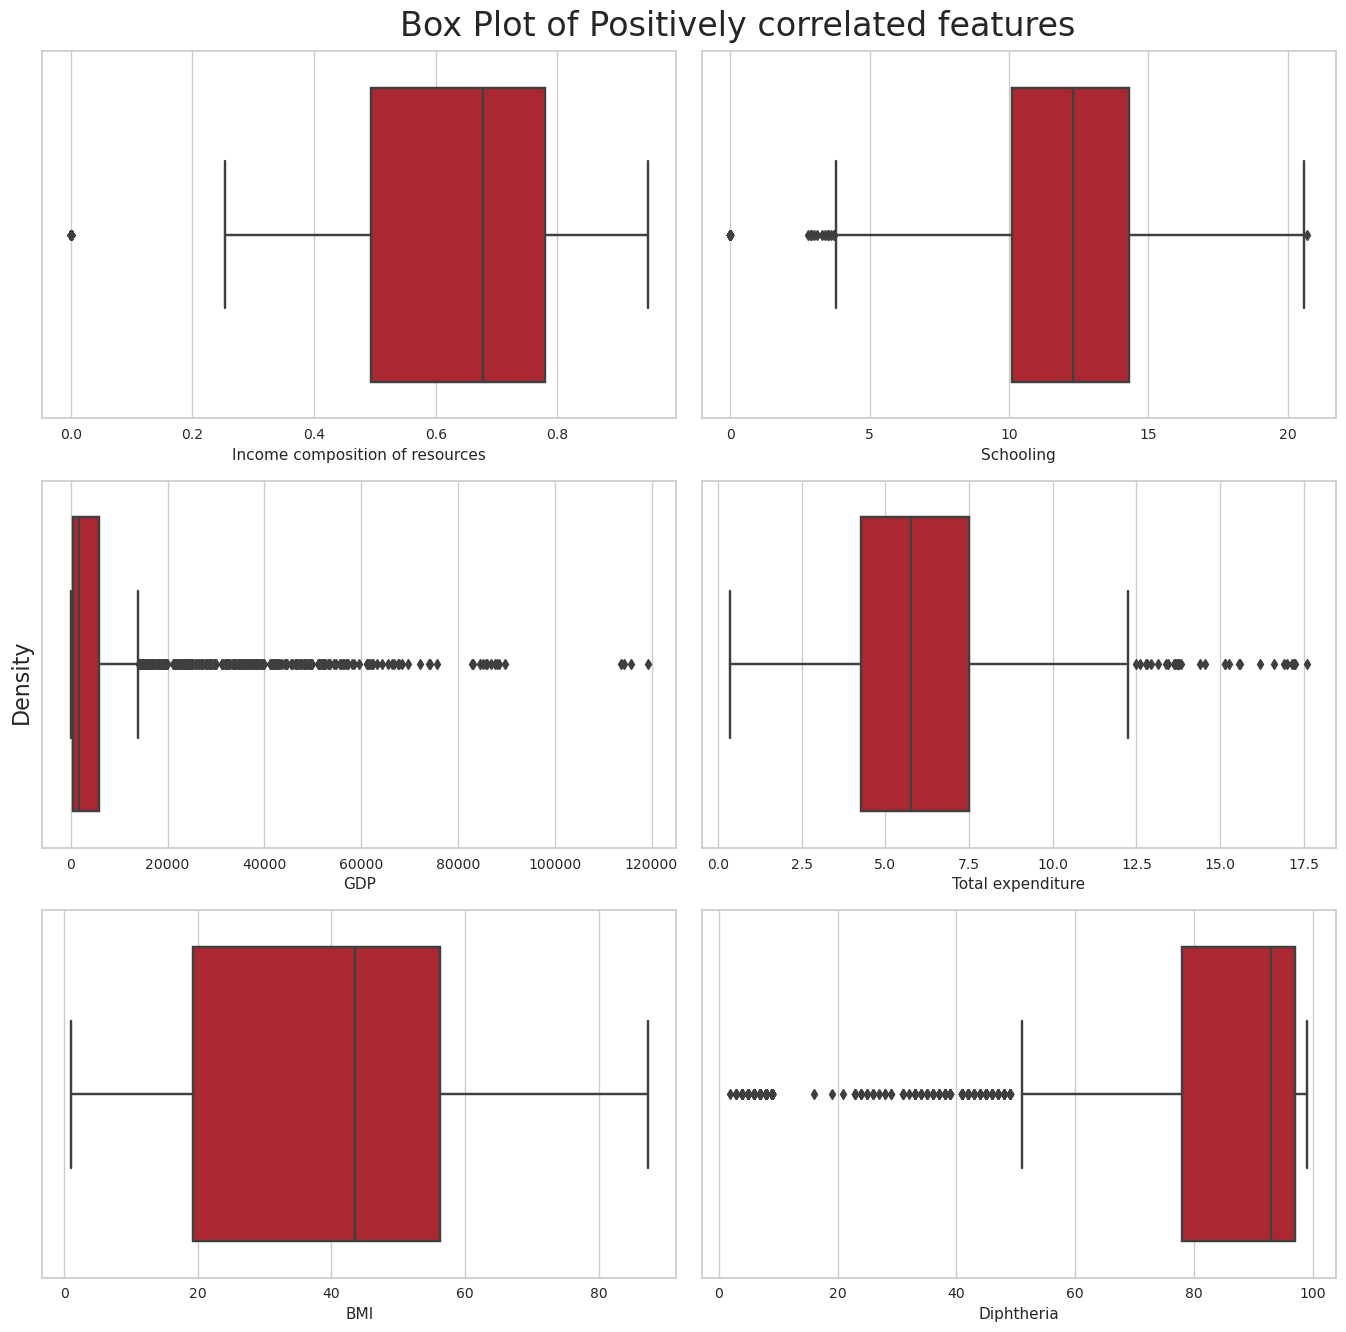

In [19]:
title = 'Box Plot of Positively correlated features'
plot_boxplot(df_life, pos_correlated_features, title)

In [20]:
title = 'Distribution of Negatively correlated features'
plot_boxplot(df_life, neg_correlated_features, title)

**Takeaways**
- After the exploratory analysis, it was possible to notice that the dataset seems to have a significant amount of outliers that will need to be treated. It is possible that some of these outliers are actually valid data, as some countries may have metrics that are very different from the others. China and India, for example, have a population almost 5 times larger than the third most populous country in the world, the USA. However, it is also plausible to assert that some of these outliers may be errors during data computation. This will be better evaluated during the data cleaning stage.
- Finally, it was also noticeable through the scatter plot that the target variable has strong linear relationships with several of the analyzed metrics.

# Preprocessing <a class="anchor" id="chapter5"></a>

* [Data Cleaning](#section_5_1)
    * [Missing](#section_3_1)
    * [Outliers](#section_3_1)
* [Feature Selection/Enineering/Scaling](#section_5_2)
* [Pipeline](#section_5_3)

<br/>

For the sake of readability and maintenance, most of the transformations made in this stage will be inserted into a Pipeline, and the remaining transformations, for practicality reasons, will be included within the preprocessor() function.

In addition, before any transformation in the dataset, the data will be split into training and testing sets. Although the final model would probably perform better if we removed all outliers from the dataset or imputed missing values based on statistical measures of the entire column before the split, this would result in a less robust model for new data. This is because, in production, it is possible to encounter missing data, outliers, and all sorts of noise, so it is necessary for the model to be able to adjust well to these scenarios.

## Data Cleaning <a class="anchor" id="section_5_1"></a>

An important highlight is that both missing values and possible outliers would be easy to verify, as all this data is public and easily accessible. However, the goal here is to address the problem with the best possible practices with the information and/or lack thereof, without using external sources.

### Missing

As shown in the table below, there is a significant amount of missing data.

**Strategies to handle missing data::**

- Since the dataset contains the indices for each country's last 14 years, the first strategy is to fill in the missing values for a given year with the mean of the other years without missing values. However, when performing this substitution, few values are changed, meaning that most countries that do not have any records for a given index do not have them for the entire period.


- The second option, complementing the first, will be to use the Scikit Learn class `KNNImputer()`. This function imputes missing values with the mean of the values found for the nearest neighbors in the training set.

Unlike a SimpleImputer, instead of filling in with mean values from the entire column, KNNImputer will find similarities between instances and impute values based on that proximity.

https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

In [21]:
#Missing Values
pd.DataFrame(df_life.isnull().mean().sort_values(ascending=False)*100, columns=['% Missing'])

% Missing
Population                       22.191967
Hepatitis B                      18.822328
GDP                              15.248468
Total expenditure                 7.692308
Alcohol                           6.603131
Income composition of resources   5.684139
Schooling                         5.547992
Thinness 5-9 years                1.157250
Thinness 10-19 years              1.157250
BMI                               1.157250
Polio                             0.646698
Diphtheria                        0.646698
Life expectancy                   0.340368
Adult Mortality                   0.340368
HIV/AIDS                          0.000000
Country                           0.000000
Year                              0.000000
Measles                           0.000000
Percentage expenditure            0.000000
Infant deaths                     0.000000
Status                            0.000000
Under-five deaths                 0.000000

### Outliers

- During the exploratory data analysis, it was observed that there are a significant number of potential outliers based on the distributions and boxplots. The statistical description of the dataset confirms this hypothesis. Several features have values that are far apart between their quartiles, such as 'HIV/AIDS', which has a value up to the third quartile of 0.8 and a maximum value of 50.6.

    - **Identifying outliers:**
        - To identify outliers, a class will be defined that uses the 1st quartile (Q1), 3rd quartile (Q3), and Interquartile Range (IQR) as criteria.<br/>
        - Values below $Q1 - (1.5 \times IQR)$ or above $Q3 + (1.5 \times IQR)$ will be considered outliers.
    - **Dealing with outliers:**
        - After identifying the outliers, one option would be to remove them, but this would cause a significant loss of information. The adopted option will be to replace these values with missing values and then fill them using the KNNImputer.


In [22]:
df_life.describe()

Year  Life expectancy  Adult Mortality  Infant deaths  \
count  2938.000000      2928.000000      2928.000000    2938.000000   
mean   2007.518720        69.224932       164.796448      30.303948   
std       4.613841         9.523867       124.292079     117.926501   
min    2000.000000        36.300000         1.000000       0.000000   
25%    2004.000000        63.100000        74.000000       0.000000   
50%    2008.000000        72.100000       144.000000       3.000000   
75%    2012.000000        75.700000       228.000000      22.000000   
max    2015.000000        89.000000       723.000000    1800.000000   

           Alcohol  Percentage expenditure  Hepatitis B        Measles  \
count  2744.000000             2938.000000  2385.000000    2938.000000   
mean      4.602861              738.251295    80.940461    2419.592240   
std       4.052413             1987.914858    25.070016   11467.272489   
min       0.010000                0.000000     1.000000       0.000000   
25%       0.877500                4.685343    77.000000       0.000000   
50%       3.755000               64.912906    92.000000      17.000000   
75%       7.702500              441.534144    97.000000     360.250000   
max      17.870000            19479.911610    99.000000  212183.000000   

               BMI  Under-five deaths        Polio  Total expenditure  \
count  2904.000000        2938.000000  2919.000000         2712.00000   
mean     38.321247          42.035739    82.550188            5.93819   
std      20.044034         160.445548    23.428046            2.49832   
min       1.000000           0.000000     3.000000            0.37000   
25%      19.300000           0.000000    78.000000            4.26000   
50%      43.500000           4.000000    93.000000            5.75500   
75%      56.200000          28.000000    97.000000            7.49250   
max      87.300000        2500.000000    99.000000           17.60000   

        Diphtheria     HIV/AIDS            GDP    Population  \
count  2919.000000  2938.000000    2490.000000  2.286000e+03   
mean     82.324084     1.742103    7483.158469  1.275338e+07   
std      23.716912     5.077785   14270.169342  6.101210e+07   
min       2.000000     0.100000       1.681350  3.400000e+01   
25%      78.000000     0.100000     463.935626  1.957932e+05   
50%      93.000000     0.100000    1766.947595  1.386542e+06   
75%      97.000000     0.800000    5910.806335  7.420359e+06   
max      99.000000    50.600000  119172.741800  1.293859e+09   

       Thinness 10-19 years  Thinness 5-9 years  \
count           2904.000000         2904.000000   
mean               4.839704            4.870317   
std                4.420195            4.508882   
min                0.100000            0.100000   
25%                1.600000            1.500000   
50%                3.300000            3.300000   
75%                7.200000            7.200000   
max               27.700000           28.600000   

       Income composition of resources    Schooling  
count                      2771.000000  2775.000000  
mean                          0.627551    11.992793  
std                           0.210904     3.358920  
min                           0.000000     0.000000  
25%                           0.493000    10.100000  
50%                           0.677000    12.300000  
75%                           0.779000    14.300000  
max                           0.948000    20.700000

In [23]:
#Class to replace outliers
class OutliersRemover(BaseEstimator, TransformerMixin):
    def __init__(self, baseline=1.5):
        self.baseline = baseline
        
    def fit(self, X, y=None):
        X = check_array(X, force_all_finite=False) #If non-array, transform into an array
        q1 = np.nanquantile(X, 0.25, axis=0) #First quartile
        q3 = np.nanquantile(X, 0.75, axis=0) #Third quartile
        IQR = q3 - q1
        self.lower_bound = q1 - (self.baseline * IQR)
        self.upper_bound = q3 + (self.baseline * IQR)
        self.n_features_in_ = X.shape[1]
        return self
    
    def transform(self, X, y=None):
        check_is_fitted(self)
        X = check_array(X, force_all_finite=False)
        assert self.n_features_in_ == X.shape[1]
        X_transformed = X.copy()
        X_transformed = np.where(((X_transformed < self.lower_bound) | (X_transformed > self.upper_bound)),
                                 np.nan, 
                                 X_transformed)
        
        
        return X_transformed #Returns an array

In [24]:
#Select the features
features = pos_correlated_features + neg_correlated_features

#Create a copy of the Dataframe with the selected features
df_temp = df_life[features].copy()

#Create, fit and transform the class OutliersRemover()
remove_outliers = OutliersRemover()
df_temp_without_outliers = remove_outliers.fit_transform(df_temp)

#Transform array back to a DataFrame
df_temp_transformed = pd.DataFrame(data = df_temp_without_outliers, columns = features)

#Plot boxplot
plot_boxplot(df_temp_transformed, features)

- After the transformation, there are fewer outliers compared to before. However, some features, particularly 'HIV/AIDS', 'GDP', 'Infant deaths', and 'Diphtheria', still appear to have many significantly distant values. In this case, the logarithm will be applied to these columns in an attempt to remove these more dispersed data and obtain a more uniform distribution. As can be seen in the plot below, the application of the logarithm results in better distributions, especially for the 'GDP' and 'Infant deaths' features.

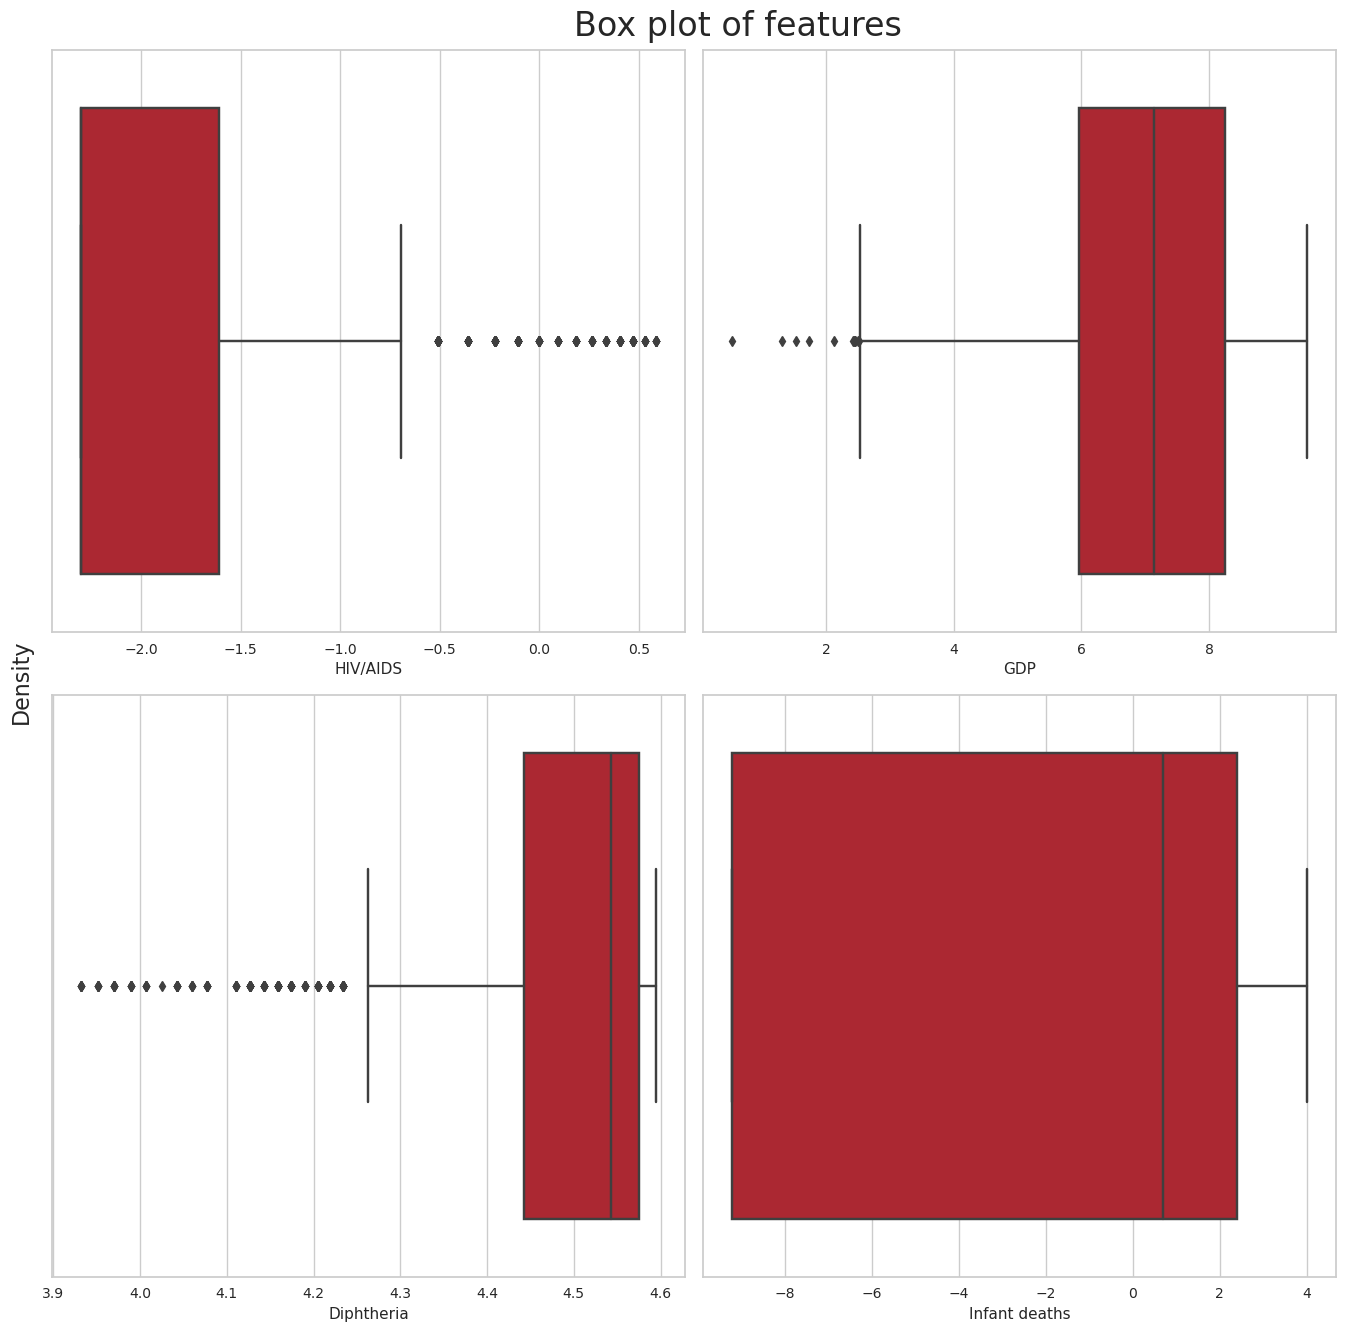

In [25]:
#Apply log transformation
columns_to_log = ['HIV/AIDS', 'GDP', 'Diphtheria','Infant deaths']

X_train_log = df_temp_transformed[columns_to_log].copy()

X_train_log= X_train_log.apply(lambda x: np.log(x + 10e-5))

plot_boxplot(X_train_log, columns_to_log)

## Feature Selection/Engineering/Scaling <a class="anchor" id="section_5_2"></a>

**Feature Selection**
- In this part, no Feature Selection algorithm will be used, only some features will be removed manually.

    - Country: OneHotEncoder could be used for this column, but the goal here is for the model to be able to evaluate the impact of different indices/metrics on life expectancy in a country.

    - Year: This is indifferent to the analysis objective.

    - Population: Since all indices are computed per capita or per 1000 inhabitants, for example, keeping this feature would only increase the complexity of the model, possibly causing overfitting problems, in addition to increasing processing time. Finally, during EDA this variable showed no direct relationship with the target.

**Feature Engineering** 
- The features 'Thinness 10-19 years' and 'Thinness 5-9 years', since they deal with the same problem in different age ranges, have a high correlation. In this case, a new feature 'Thinness 5-19 years' will be created with the value being the sum of both.

**Feature Scaling**
- Although models like RandomForest, DecisionTree, and GradientBoostingRegressor do not require feature scaling, other models that use distance-based algorithms, such as SVM, and Gradient descent based algorithms, such as Lasso, may benefit from this technique.

In [26]:
#Function to split the data and perform the preprocessing.
def preprocessing(df):
    #Create a copy of dataframe.
    df = df.copy()
    
    #Drop rows where target is null
    df.dropna(subset=['Life expectancy'], inplace=True)
    
    #Create new feature 'Thinness 5-19 years'
    df['Thinness 5-19 years'] = df['Thinness 5-9 years'] + df['Thinness 10-19 years']
    df.drop(['Thinness 5-9 years', 'Thinness 10-19 years'], axis = 1, inplace = True)
    
    #Split the target variable and the features.
    y = df['Life expectancy']
    X = df.drop('Life expectancy', axis=1)
    
    #Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=18) 
    
    #Fill missing with historical mean for each country
    ##The historical_mean is calculated only using X_train data. 
    ###It must be considered that there is no access to the test set.
    for column in X_train.columns[X_train.isna().any()]:
        historical_mean_train = X_train.groupby('Country')[column].transform('mean')
        X_train[column].fillna(historical_mean_train, inplace=True)
        X_test[column].fillna(historical_mean_train, inplace=True)
    
    X_train.drop(['Country', 'Year', 'Population', 'Status'], axis = 1, inplace = True)
    X_test.drop(['Country', 'Year', 'Population', 'Status'], axis = 1, inplace = True)
    
    return X_train, X_test, y_train, y_test

In [27]:
X_train, X_test, y_train, y_test = preprocessing(df_life)

## Pipeline <a class="anchor" id="section_5_3"></a>

A pipeline function will be created, which will contain a Pipeline object with all the transformations that were described earlier. This function will receive a regression model as an argument, which will be included in the final pipeline. The final pipeline will be composed of the preprocessing steps and the regression.

In [28]:
#Pass this function inside FunctionTransformer instead of passing just np.log to avoid cases with values equal zerodef log_transform(X):
def log_transform(X):    
    return np.log(X + 10e-5)

In [29]:
def pipeline(regressor):
    # define list of features that are known to be skewed in the dataset
    skewed_features = ['HIV/AIDS', 'GDP', 'Diphtheria', 'Infant deaths']
    
    # define list of numerical features that are not skewed
    numerical_features = [feature for feature in X_train.columns 
                        if feature not in skewed_features]
    
    # define pipeline for numerical features
    numerical_transformer = Pipeline(
        steps=[
            ('outliers', OutliersRemover()), # remove outliers from data
            ('impute', KNNImputer()), # impute missing values using K-Nearest Neighbors
            ('scaling', StandardScaler()), # scale features to have mean 0 and unit variance
        ]
    )
    
    # define pipeline for skewed features
    skewed_transformer = Pipeline(
        steps=[
            ('outliers', OutliersRemover()), # remove outliers from data
            ('log', FunctionTransformer(log_transform)), # apply natural logarithm transformation to skewed features
            ('impute', KNNImputer()), # impute missing values using K-Nearest Neighbors
            ('scaling', StandardScaler()), # scale features to have mean 0 and unit variance
        ]
    )
    
    # define ColumnTransformer to apply each pipeline to appropriate features
    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical_transformer', numerical_transformer, numerical_features), # apply numerical pipeline to numerical features
            ('skewed_transformer', skewed_transformer, skewed_features) # apply skewed pipeline to skewed features
        ],
        remainder='passthrough' # pass through any remaining features
    )

    # define final pipeline, consisting of preprocessor and regressor
    model = Pipeline(
        steps=[
            ('preprocessor', preprocessor), # apply preprocessor to data
            ('regressor', regressor) # apply regressor to preprocessed data
        ]
    )

    return model

# Modeling <a class="anchor" id="chapter6"></a>


- First, a set of regressors with default parameters will be tested and evaluated. The models that perform better in cross-validation will be tuned using RandomizedSearchCV().

- For this problem, the Root Mean Squared Error (RMSE) and R-squared will be used as performance metrics.

In [30]:
#Dict with the regressors
models = {
    "Linear Regression (Ridge)": pipeline(Ridge()),
    "Decision Tree": pipeline(DecisionTreeRegressor()),
    "Support Vector Regression": pipeline(SVR()),
    "Neural Network": pipeline(MLPRegressor()),
    "Random Forest": pipeline(RandomForestRegressor()),
    "Gradient Boosting": pipeline(XGBRegressor())
}

In [31]:
#Function that performs cross validation on the model and returns the mean of RMSE and R^2 for that model.
def evaluate_model(model, X_train, y_train):

    cv = cross_validate(model, 
                        X_train, y_train,
                        cv = 5,
                        scoring = ('neg_root_mean_squared_error','r2'))

    return np.mean(-cv['test_neg_root_mean_squared_error']), np.mean(cv['test_r2'])

In [32]:
#Run all models through cross validation and get the mean of each one.
models_name = []
models_rmse = []
models_r2 = []

for name, model in models.items():
    rmse, r2 = evaluate_model(model, X_train, y_train)
    models_name.append(name)
    models_rmse.append(rmse)
    models_r2.append(r2)

df_models = pd.DataFrame(data = 
                         {'Mean RMSE in CV' : models_rmse,
                          'Mean R2 in CV' : models_r2
                         }, 
                         index = models_name)

In [33]:
#Mean performance of each model in cross-validation.
display(df_models)

Mean RMSE in CV  Mean R2 in CV
Linear Regression (Ridge)         3.947796       0.826436
Decision Tree                     3.481487       0.864494
Support Vector Regression         4.000662       0.821505
Neural Network                    6.400482       0.542274
Random Forest                     2.483666       0.930548
Gradient Boosting                 2.678898       0.920050

In [34]:
#Function to plot feature importance provided the models.
def plot_feature_importance(df):   
    
    df = df.sort_values(by = '% Importance',
                                ascending = False).copy()
    
    df_temp = df['% Importance'].sort_values()
    
    display(df)
    
    fig, ax = plt.subplots(figsize=(16,16))

    bar = ax.barh(df_temp.index,
                 df_temp,
                 align = ('center'),
                 color =colors[0],
                 height = 0.9)

    ax.bar_label(bar, fmt = '%.f%%', padding=2)
    ax.set_xlabel('Importance (%)')
    ax.set_title('Feature Importance \n', fontsize=18);

% Importance
Total expenditure                   78.489783
Adult Mortality                      9.308037
Infant deaths                        2.476833
HIV/AIDS                             2.054520
Income composition of resources      1.199747
Diphtheria                           0.916969
Polio                                0.717831
Alcohol                              0.707374
Thinness 5-19 years                  0.698857
Percentage expenditure               0.644525
Under-five deaths                    0.592514
BMI                                  0.551368
Measles                              0.544956
Schooling                            0.406510
Hepatitis B                          0.393990
GDP                                  0.296184

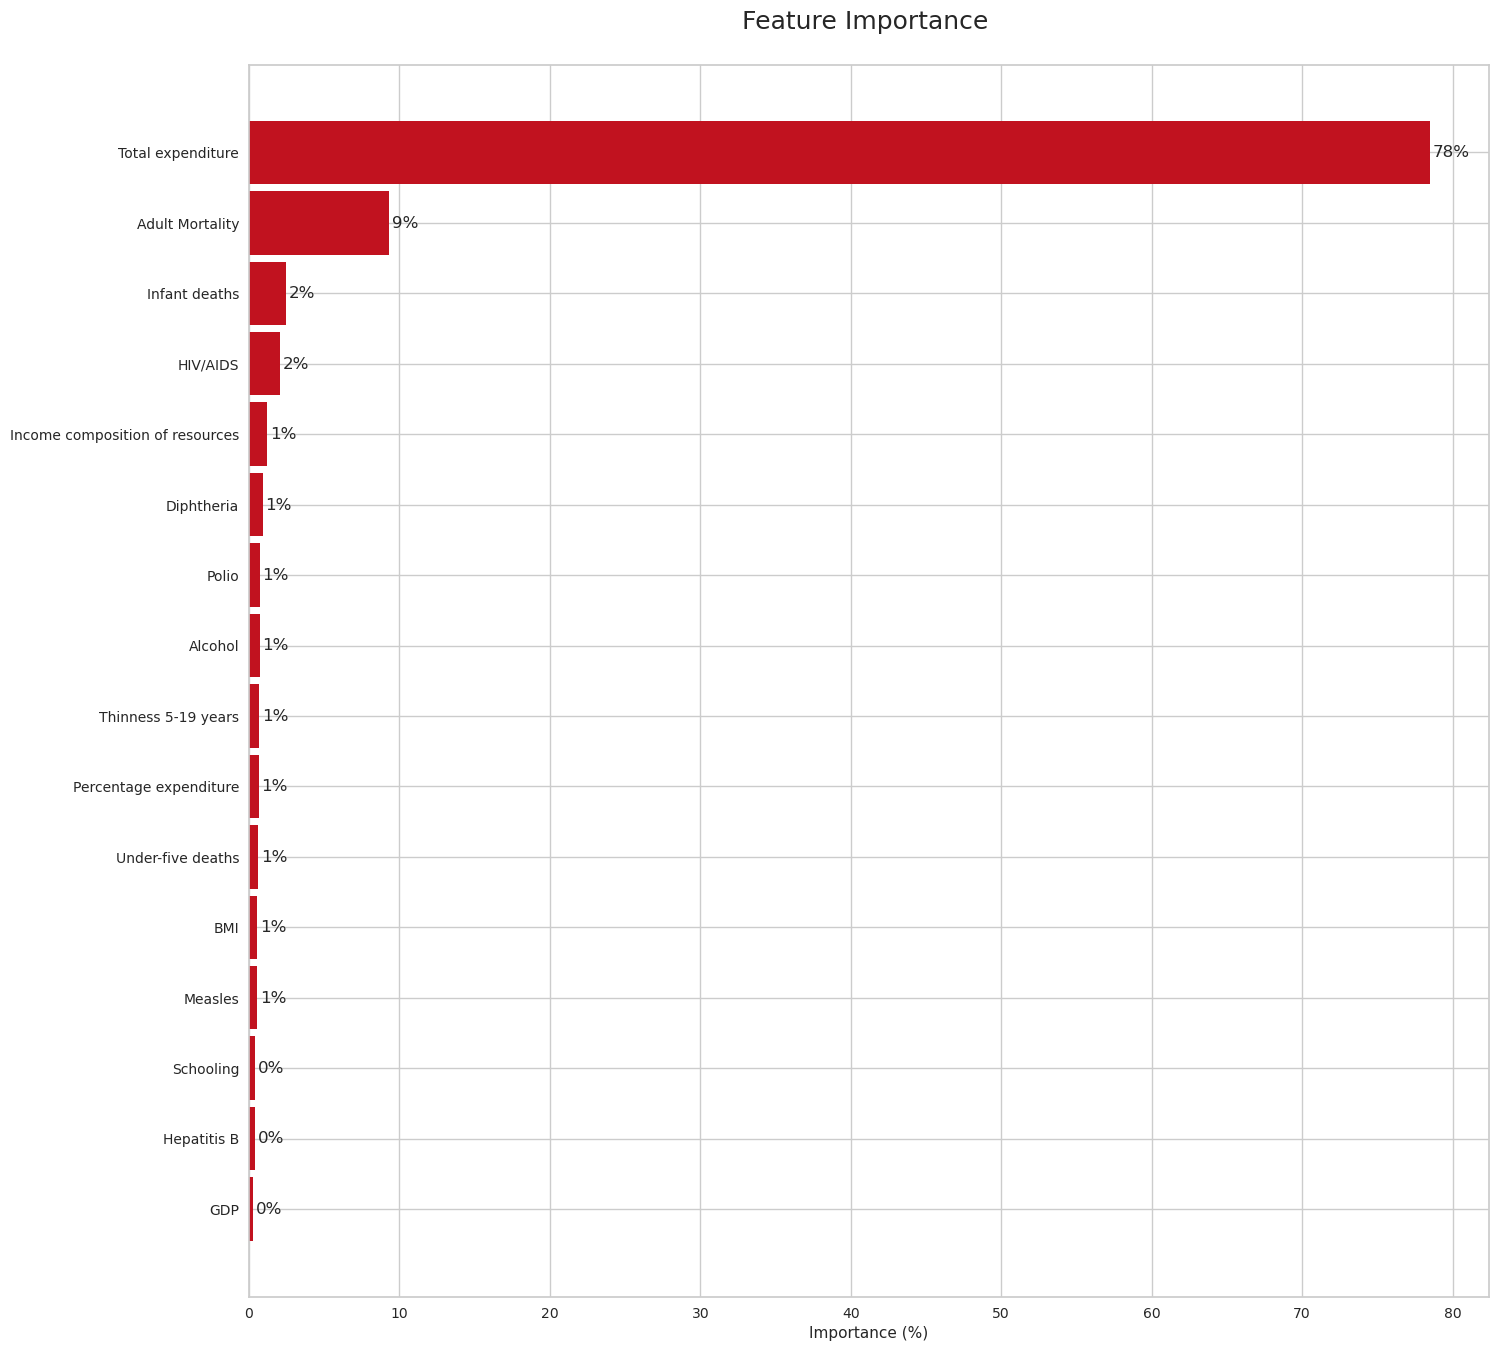

In [35]:
#Check the feature importance for Random Forest Model
models['Random Forest'].fit(X_train, y_train)

df_feature_importance = pd.DataFrame(data = 100* models['Random Forest']['regressor'].feature_importances_, 
                                  index = X_train.columns,
                                  columns = ['% Importance'])

plot_feature_importance(df_feature_importance)

- It seems that the model with the initial parameters gave a great importance to the variable "Total expenditure".

- Recalling that **Total expenditure** refers to the General government expenditure on health as a percentage of total government expenditure (%).

# Tune Model <a class="anchor" id="chapter7"></a>

- With the best models defined, parameter tuning will be performed using Randomized Search.

- The three models that performed best in cross-validation are based on decision trees, meaning they have very similar strengths and weaknesses. To increase the probability of performance of one of the models, the Lasso regression model will be used instead of the decision tree. Lasso is a model that uses gradient descent to adjust parameters and ℓ1 regularization technique.

## Randomized Search <a class="anchor" id="section_7_1"></a>

In [36]:
# Function for a Randomized Search Cross-Validation
def random_search(model, param_distribs,X_train, y_train):
    
    rnd_search = RandomizedSearchCV(model,
                                    param_distributions = param_distribs,
                                    n_iter = 10, 
                                    cv = 3,
                                    scoring = 'neg_root_mean_squared_error', # The performance metric to optimize
                                    random_state = 18)
    

    search = rnd_search.fit(X_train, y_train)
    
    # Return the best performance score and corresponding hyperparameters found by the search
    return (-search.best_score_) , (search.best_params_)

In [37]:
# Define dictionary with the best models to be tuned
best_models  = {
    "Linear Regression(Ridge)": pipeline(Ridge()),
    "Random Forest": pipeline(RandomForestRegressor()),
    "Gradient Boosting": pipeline(XGBRegressor())
}

# Define a dictionary with the hyperparameters to be searched for each model
param_distribs = {
    "Linear Regression(Ridge)": {
        "regressor__alpha": loguniform(1e-5, 100)
    },
    "Random Forest": {
        "regressor__n_estimators": randint(100, 1000),
        "regressor__max_features": ['auto', 'sqrt'],
        "regressor__max_depth": [int(x) for x in np.linspace(10, 110, num = 11)],
        "regressor__min_samples_split": [2, 5, 10],
        "regressor__min_samples_leaf": [1, 2, 4],
        "regressor__bootstrap": [True, False]
    },
    "Gradient Boosting": {
        "regressor__learning_rate": [0.01, 0.1, 0.5, 1],
        "regressor__n_estimators": randint(100, 1000),
        "regressor__max_depth": [3, 5, 7, 9],
    }
}

# Define variables to keep track of the best score, parameters and model
best_score = np.inf
best_param = None
dict_best_models = {}

# Loop through each model and perform a randomized search for hyperparameters
for name, model in best_models.items():
    # Call random_search function to optimize hyperparameters for the current model
    score, param = random_search(model, param_distribs[name], X_train, y_train)
    # Add the best model score to the dictionary
    dict_best_models.update({model['regressor']: score})
    
    # Check if the score for the current model is better than the best score so far
    if score < best_score:
        best_score = score
        best_param = param
        best_model = model

In [38]:
list_best_models = list(dict_best_models.items())

#Extract the name of the models
list_best_models_renamed = [str(list_best_models[0][0])[:5], 
                            str(list_best_models[1][0])[:21], 
                            str(list_best_models[2][0])[:12]]

# Extract the score for each model
list_best_models_score = [score[1] for score in list_best_models]

# Extract the score for each model
df_best_models = pd.DataFrame(data = list_best_models_score,
                             index = list_best_models_renamed,
                             columns = ['RMSE'])
display(df_best_models)

RMSE
Ridge                  3.976160
RandomForestRegressor  2.572100
XGBRegressor           2.533611

# Validation <a class="anchor" id="chapter8"></a>

- With the model that performed best in the RandomizedSearchCV, the performance will be evaluated using the test data, which are completely new to the model.

In [39]:
best_param = {param.replace('regressor__', ''): value for param, value in best_param.items()}

final_model = pipeline(XGBRegressor(**best_param))
final_model.fit(X_train, y_train)

display(final_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_transformer',
                                                  Pipeline(steps=[('outliers',
                                                                   OutliersRemover()),
                                                                  ('impute',
                                                                   KNNImputer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['Adult Mortality', 'Alcohol',
                                                   'Percentage expenditure',
                                                   'Hepatitis B', 'Measles',
                                                   'BMI', 'Under-five deaths',
                           

In [40]:
#Test the best model first in cross-validation, to evaluate if there was an increase in the average performance
rmse_train_final_model, r2_train_final_model = evaluate_model(final_model,X_train, y_train)

df_final_model_cv = pd.DataFrame(data = [rmse_train_final_model, r2_train_final_model], 
                              index = ['RMSE', 'R2'],
                              columns = ['Final Model Performance in CV'])

display(df_final_model_cv)

Final Model Performance in CV
RMSE                       2.416232
R2                         0.934868

- As we can see, the model with tuned parameters increased the average performance, going from an initial RMSE of 2.655139 to 2.436900. Finally, this model will be evaluated on the Test set.

In [41]:
y_pred = final_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

df_final_model = pd.DataFrame(data = [rmse, r2], 
                              index = ['RMSE', 'R2'],
                              columns = ['Final Model Performance in Test'])

df_final_model

Final Model Performance in Test
RMSE                         2.640774
R2                           0.924113

% Importance
Total expenditure                   83.163857
Under-five deaths                    3.089219
Adult Mortality                      2.414824
HIV/AIDS                             1.686062
Thinness 5-19 years                  1.438160
Infant deaths                        1.350521
BMI                                  1.297658
Measles                              0.826333
Diphtheria                           0.778105
Polio                                0.729580
Schooling                            0.701794
GDP                                  0.694178
Percentage expenditure               0.529273
Alcohol                              0.485443
Income composition of resources      0.451624
Hepatitis B                          0.363365

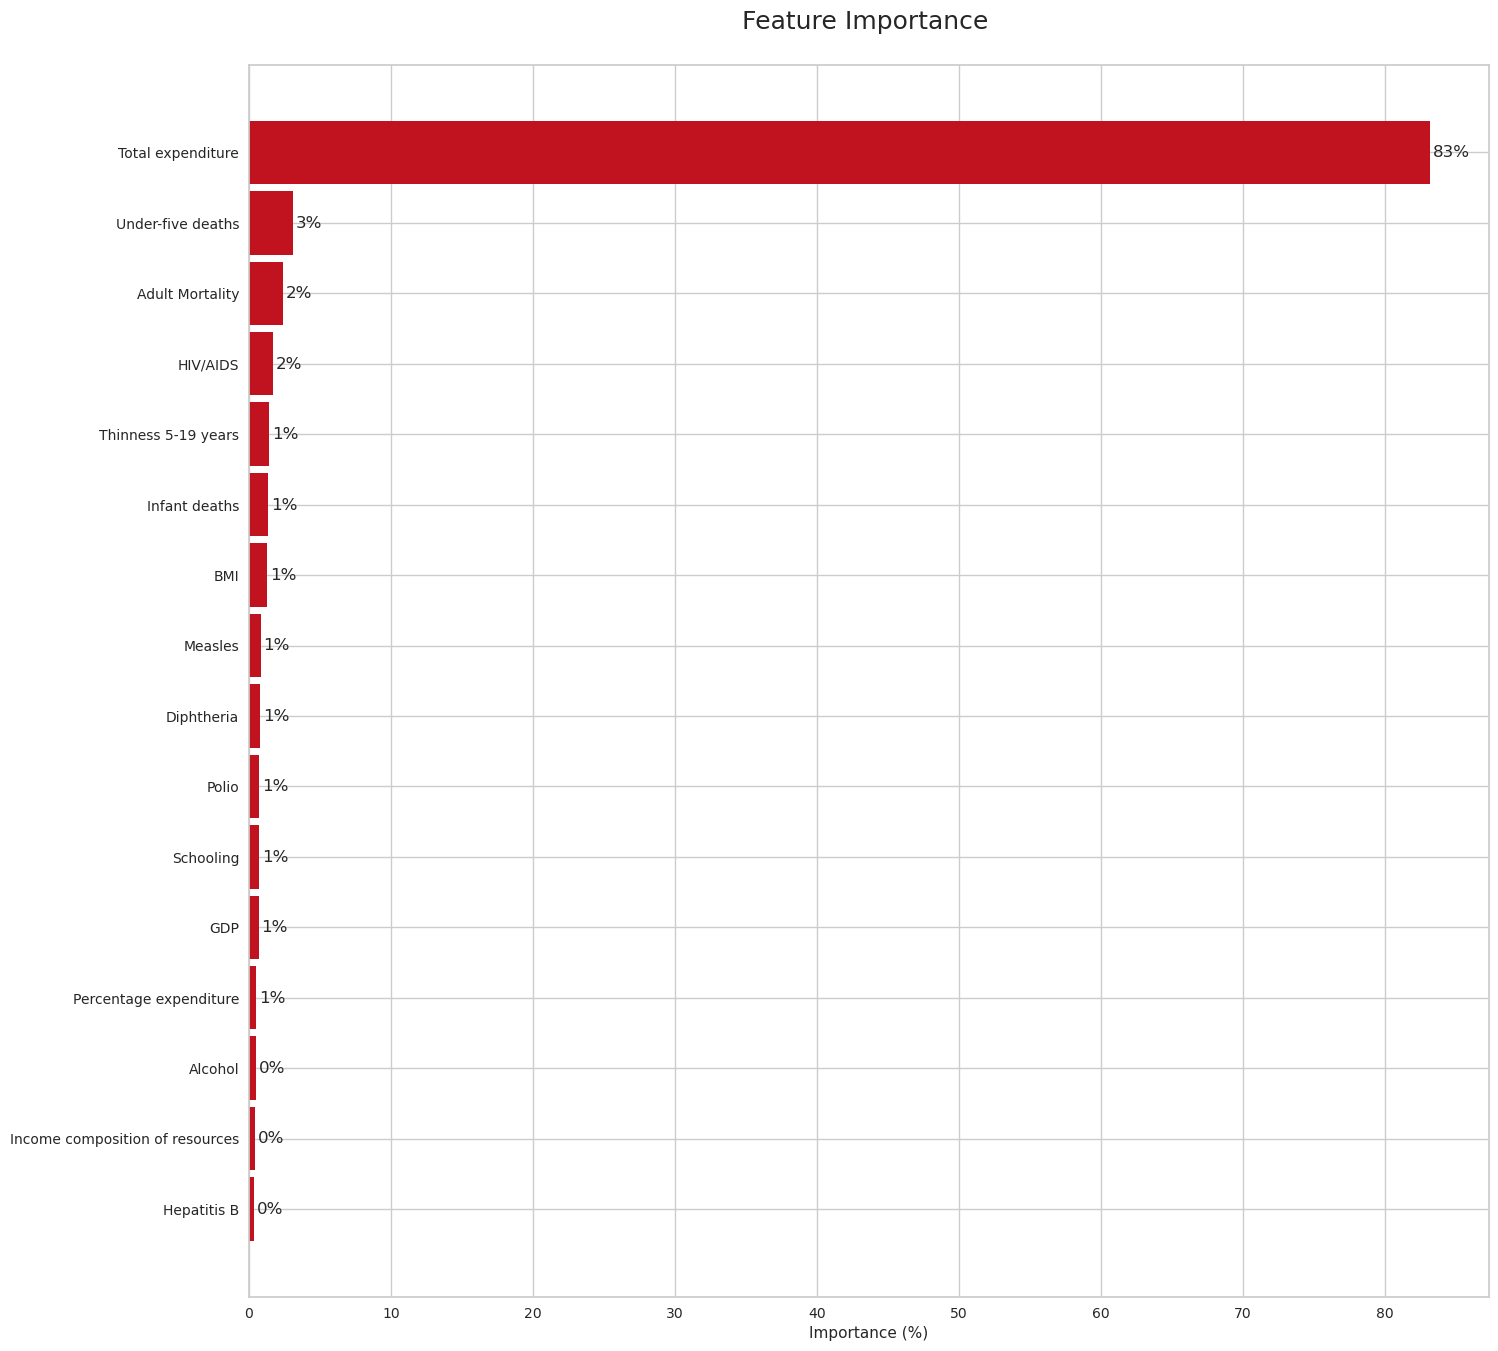

In [42]:
df_feature_importance = pd.DataFrame(data = 100* final_model['regressor'].feature_importances_, 
                                  index = X_train.columns,
                                  columns = ['% Importance'])

plot_feature_importance(df_feature_importance)

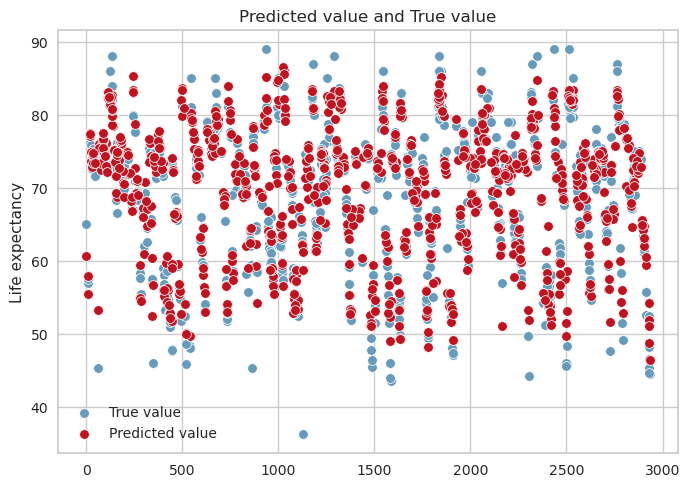

In [43]:
sns.scatterplot(x = X_test.index, y = y_test, color=colors[1], label = "True value")
sns.scatterplot(x = X_test.index, y = y_pred, color=colors[0], label = "Predicted value");

plt.title('Predicted value and True value');

In [44]:
#Plot prediction error
fig, ax = plt.subplots(figsize=(10,12))

pred_error = PredictionError(final_model, scatter_kwargs={'color': 'red'})
pred_error.fit(X_train, y_train)
pred_error.score(X_test, y_test)
pred_error.show();

In [45]:
visualizer = ResidualsPlot(final_model,
                           train_color = colors[0],
                           test_color = colors[1],
                           hist = False, 
                           qqplot = True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

# Conclusion <a class="anchor" id="chapter9"></a>

- The model performed slightly worse on the test data, however, it still maintained results very close to those performed on the training data, indicating that the model is not suffering from overfitting problems and is robust to new data. In addition, the value of RMSE, when compared to the target scale, is great, indicating that the model is able to predict the life expectancy of a particular country based on the other metrics provided.

- By analyzing the errors made by the model, it is possible to notice that most of the errors occurred in countries where life expectancy is significantly above or below the average when compared to other countries. Therefore, the model is able to predict life expectancy well for most cases, but with room for improvement for extreme cases.

- From the residuals plot, it can be noticed that the problem fits well to linear models, since the points are randomly scattered around the axis.

- It is important to note that the model gives significant weight to the 'Total expenditure' variable, which is plausible, as this metric refers to government spending on health, indicating that countries that spend more on health for the population have higher life expectancy. 